### Spherical Feature Extraction using Spherical_UNet

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

import torch
from torch import nn
from sconv.module.sconv import SphericalConv
from torch.autograd import Variable

print(torch.__version__)
from distutils.version import LooseVersion
import sys
assert sys.version_info >= (3, 6), \
    f"Python version greater than 3.6 is required, current version is {sys.version}."
assert LooseVersion(torch.__version__) < LooseVersion('0.4.0'), \
    f"Torch version greater than 0.3.1 is not supported, current version is {torch.__version__}."

0.3.1.post2


In [2]:
class Spherical_UNet(nn.Module):
    def __init__(self):
        super(Spherical_UNet, self).__init__()
        self.conv1 = SphericalConv(3  , 64 , np.pi/32, kernel_size=(8, 16), kernel_sr=None)
        self.conv2 = SphericalConv(64 , 128, np.pi/16, kernel_size=(4,  8), kernel_sr=None)
        self.conv3 = SphericalConv(128, 256, np.pi/4 , kernel_size=(4,  8), kernel_sr=None)
        self.conv4 = SphericalConv(256, 256, np.pi   , kernel_size=(8, 16), kernel_sr=None)
        self.relu  = nn.ReLU(inplace=True)
        self.pool  = nn.MaxPool2d(2, 2)
        
    def forward(self, image):
        x = self.conv1(image)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.pool(x)
        return x

In [3]:
"""
spherical_UNet = Spherical_UNet()
img = Variable(torch.rand(1, 3, 128, 256), requires_grad=True)
out = spherical_UNet(img)

print('img.shape: ', img.shape)
print('out.shape: ', out.shape)
#print(spherical_UNet)
"""

"\nspherical_UNet = Spherical_UNet()\nimg = Variable(torch.rand(1, 3, 128, 256), requires_grad=True)\nout = spherical_UNet(img)\n\nprint('img.shape: ', img.shape)\nprint('out.shape: ', out.shape)\n#print(spherical_UNet)\n"

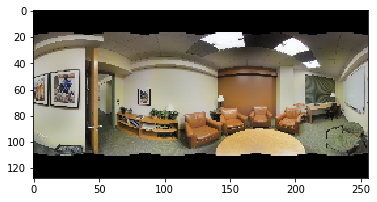

In [4]:
path = 'C:/Users/ustundag/Desktop/test_pano_rgb.png'
img  = Image.open(path)
img  = img.resize((256,128))
data = np.asarray(img, dtype=np.float32)
data = data.reshape(data.shape[2], data.shape[0], data.shape[1])
data = torch.from_numpy(data)
data = data.unsqueeze_(0)
data = data[:,:3,:,:]
plt.imshow(img)
plt.show()

torch.Size([1, 256, 8, 16])


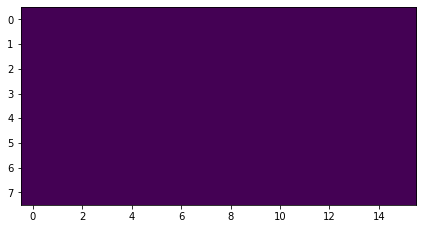

In [5]:
spherical_UNet = Spherical_UNet()
fmap = spherical_UNet(Variable(data, requires_grad=True))
print(fmap.shape)

x = fmap.data.numpy()
plt.figure(figsize=(8, 8))
for i in range(1):
    plt.subplot(2, 1, i + 1)
    plt.imshow(x[0,i,:,:])
plt.show()

### Extract and save features of 7 specific objects using semantics as masks

In [16]:
import sys
sys.path.append('C:/Users/ustundag/GitHub/2D-3D-Semantics')
import assets.utils as u
VALID_OBJECTS = ('board','bookcase','chair','door','sofa','table','window')

import glob
from scipy.io import savemat, loadmat
from IPython.display import display, clear_output

def get_label(pix):
    labels = u.load_labels('C:/Users/ustundag/Github/2D-3D-Semantics/assets/semantic_labels.json')
    limit = len(labels)
    i = u.get_index(pix)
    if i < limit:
        instance_label = labels[i]
        instance_label_as_dict = u.parse_label(instance_label)
        label = instance_label_as_dict["instance_class"]
        return label
    return '<UNK>' # unknown in case index is out of bounds in "labels.json" file

def image2tensor(path):
    img = Image.open(path)
    img = img.resize((256,128))
    img = np.asarray(img, dtype=np.float32)
    img = img.reshape(img.shape[2], img.shape[0], img.shape[1])
    tensor = torch.from_numpy(img)
    tensor = tensor.unsqueeze_(0)
    tensor = tensor[:,:3,:,:]
    return tensor

def save_features_and_labels(file):
    paths = glob.glob("C:\\Users\\ustundag\\GitHub\\2D-3D-Semantics\\area_3\\pano\\rgb\\*.png")
    features = []
    labels = []
    spherical_UNet = Spherical_UNet()

    i = 1
    for path in paths:
        clear_output(wait=True)
        tensor = image2tensor(path)
        fmap = spherical_UNet(Variable(tensor, requires_grad=True))
        fmap = fmap.data.numpy() # torch.Size([1, 256, 8, 16])
        fmap = fmap.reshape(fmap.shape[0], fmap.shape[1], fmap.shape[2]*fmap.shape[3])

        # Replace 2 occurrences to find counterpart of RGB image as Semantic
        sem_file = path.replace("rgb", "semantic", 2)
        sem_img  = np.asarray(Image.open(sem_file).resize((16,8)))
        sem_pixels = sem_img.reshape(sem_img.shape[0]*sem_img.shape[1], sem_img.shape[2])
        valid_indexes = [[np.argwhere((sem_pixels == p).all(axis=1))[0,0], get_label(p)]
                            for p in sem_pixels
                            if get_label(p) in VALID_OBJECTS]
        # first value = feature index, second value = label
        for idx in valid_indexes:
            features.append(fmap[0,:,idx[0]])
            labels.append(VALID_OBJECTS.index(idx[1]))

        display(str(i) + " / 85")
        i += 1
    
    savemat(file,{'features': np.asarray(features),
                  'labels'  : np.asarray(labels)})

In [17]:
file = 'area_3_data_pano_spherenet_UNet_dims_256_128_16_8_relu_after_onlyConv.mat'
save_features_and_labels(file)

'85 / 85'

In [18]:
data = loadmat("C:\\Users\\ustundag\\GitHub\\2D-3D-Semantics\\Saliency-detection-in-360-video_TORCH\\"+file)
features = data["features"]
labels   = data["labels"]

In [19]:
features.shape

(1530, 256)

In [20]:
labels.shape

(1, 1530)